# Derived allele frequencies and counts

To summarise what Moi's pipeline does:

- Checks the sites which any of the samples indicated (can include chimp or not) are different (SNP). If there is a sample with a different allele, then, it polarise the alleles in ancestral or derived allele depending on which outgroup you indicate (I use chimp, but we can use another as the ancestral allele inference from 1000GP).

- It outputs 3 files (similar strategy as the C-tools):
    - <filename>.geno: the genotypes for each individual (in columns) for each variable site (in rows). 0 means ancestral allele, 1 means derived allele and “.” means no information.
    - <filename>.snps: it corresponds to the position in the X chromosome. Each row corresponds to the rows in the geno file.
    - <filename>.inds: This file has listed the individuals used to check the variable sites. The order that they appear in this file, corresponds to the column-order in the geno file.
    
- Once we get those files, the pipeline runs a process that counts how many missing genotypes we have per each position (using the geno file). This file is named as <filename>.miss
- Finally, there is an script called sfs.py which you can define the following variables:
    - a dictionary for populations: name of the group of samples that you want to use to count the SFS and some other variables listed below. For instance, I defined Africans and NonAfricans
        - list with samples: this list indicates which samples belong to which group. Samples can be repeated in multiple populations
        - downsampling: This allows you to limit the sampling of alleles in each populations. Let’s say that you are comparing two populations: Africans, with 10 ind and nonAfricans with 100. Since comparing two SFSs from different populations with different sample size is complicated, it is good to downsample the population with more alleles to make a fare comparison of the counts.
    - minimum callability allowed: This defines a minimum callability in all the populations for a loci to be considered. If this variable is set to 0.8, it means that 80% of the individuals have to be called for a given position in both populations independently: 80% in Africans and 80% in NonAfricans. If the downsampling variable (explained above) is not defined, then, 80% of the alleles are going to be sampled, therefore, the downsample value must be less than this variable.
    - windowsize: This variable allows you to change the window size that you want to count the SFS for.

This script outputs a file (sfs.txt) which have the following information:
    
1. Population > which population the counts belong to
2. start > start position of the window
3. end > end position of the window
4. alleles with derived variant > (self explanatory)
5. counts > counts of the number of variants that certain number of individuals have the derived allele (field 4) ) in that given region (fields 2 and 3)) for that given population (field 1)).

Finally, I run two times my pipeline with different sets of variables:

1) Check sfs for variable sites only in humans, in two populations (Africans and NonAfricans), using Chimp to polarise the variant sites and check SFSs in 100kb windows. It has 508649 SNPs.

The outputs for this set of variables are in :

~/simons/faststorage/people/moi/X_chrom_Kasper/out/derived_alleles_pol_in_humans

2) Check sfs for variable sites comparing all the samples including Chimp, in two populations (Africans and NonAfricans, excluding Chimp), using Chimp to polarise the variant sites and check SFSs in 100kb windows. It has 1516667 SNPs (3 times more variants than the previous).

The outputs are in:

~/simons/faststorage/people/moi/X_chrom_Kasper/out/derived_alleles_pol_in_chimp_and_humans

When the variables defined as explained in the second set, the whole process took less than 15 min. Therefore, we can run multiple times the pipeline changing the variables if need be.


Hi Kasper,

I’ve ran the pipeline again with the ancestral allele file instead of the Chimp for both, call segregating sites and polarise them.

I’ve downloaded the ancestral alleles file from:

ftp://ftp.ensembl.org/pub/release-58/fasta/homo_sapiens/dna/

Since I found this 1000G project entry that talk about this ensembl release:

http://www.internationalgenome.org/category/variants/

Following the strategy that I explain in the previous email, I put all the output files in:

~/simons/faststorage/people/moi/X_chrom_Kasper/out/derived_alleles_pol_in_ancestral_and_humans/

I haven’t check the SFS directly. However, I can see that the weight of the geno file is between when I include Chimp and when I didn’t:

Not including chimp to get polymorphic sites and polarising with chimp -> 80M
Including chimp to get polymorphic sites and polarising with chimp -> 238M
Including ancestral allele fasta to get polymorphic sites and polarising with ancestral allele fasta -> 105M

We can do some plots and talk about it when you are back!

Hope you get well soon!

Moi

In [1]:
import re, os, sys, pickle, pickle, itertools
from pathlib import Path
import numpy as np
import pandas as pd
import scipy
from pandas import DataFrame, Series
from sklearn.decomposition import PCA

# my own libaries
from ChromosomeWindows import window
import genominterv

np.random.seed(7)

Plotting setup:

In [2]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_context("paper")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

def stairs(df, start='start', end='end', pos='pos', endtrim=0):
    "Turn a df with start, end into one with pos to plot as stairs"
    df1 = df.copy(deep=True)
    df2 = df.copy(deep=True)
    df1[pos] = df1[start]
    df2[pos] = df2[end] - endtrim
    return pandas.concat([df1, df2]).sort_values([start, end])

Ignore deprecation warnings from mainly seaborn:

In [3]:
# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

Import variables global to the entire analysis:

In [4]:
import analysis_globals as ag

Local code in the scripts dir on the cluster:

In [5]:
scripts_dir = ag.root_dir / 'scripts'
if str(scripts_dir) not in sys.path:
    sys.path.append(str(scripts_dir))

import simons_meta_data
import hg19_chrom_sizes

## Load meta data

In [6]:
# easy loading of meta data in a consistent manner across code
meta_data_dir = Path(os.environ['HOME'], 'simons/faststorage/data/metadata')
individuals, populations, regions = simons_meta_data.get_meta_data(meta_data_dir=meta_data_dir)

pop_categories = pd.read_hdf(str(ag.results_dir / 'population_categories.store'), 'sr')
region_categories = pd.read_hdf(str(ag.results_dir / 'region_categories.store'), 'sr')
# region_colors = dict(zip(list(region_categories), 
#                          ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', 
#                           '#ff7f00', '#ffff33', '#a65628']))

region_colors = dict(zip(list(region_categories), 
                         ['#e41a1c', '#377eb8',  '#984ea3', '#4daf4a',
                          '#ff7f00', '#ffff33', '#a65628']))

chromosome_lengths = dict((k.replace('chr', ''), v) for k, v in hg19_chrom_sizes.hg19_chrom_sizes.items())

## Read extended sweep regions

In [7]:
extended_peak_regions_10 = pd.read_hdf(ag.results_dir / 'extended_peak_regions_10%.hdf')
extended_peak_regions_75 = pd.read_hdf(ag.results_dir / 'extended_peak_regions_75%.hdf')
extended_peak_regions_90 = pd.read_hdf(ag.results_dir / 'extended_peak_regions_90%.hdf')
human_chimp_low_ils_regions_chrX = pd.read_hdf(ag.results_dir / 'human_chimp_low_ils_regions_chrX.hdf')

## Read raw data instead

Read positions:

In [8]:
snps = list()
with open('/home/kmt/simons/faststorage/people/moi/X_chrom_Kasper/out/derived_alleles_pol_in_humans/derived_X.snps') as f:
    for line in f:
        snps.append(int(line.strip()))

Read indidividuals:

In [9]:
inds = list()
with open('/home/kmt/simons/faststorage/people/moi/X_chrom_Kasper/out/derived_alleles_pol_in_humans/derived_X.inds') as f:
    for line in f:
        inds.append(line.strip())

In [10]:
len(inds)

162

Read genotypes:

In [11]:
rows = list()
with open('/home/kmt/simons/faststorage/people/moi/X_chrom_Kasper/out/derived_alleles_pol_in_humans/derived_X.geno') as f:
    for line in f:
        row = list()
        for genotype in line.strip():
            if genotype == '.':
                genotype = np.nan
            else:
                genotype = int(genotype)
                assert genotype <= 1
            row.append(genotype)
        rows.append(row)
        
        

In [12]:
raw_data = pd.DataFrame(rows, columns=inds, index=snps, dtype='float16')
raw_data.head()

,S_Spanish-1,S_Burusho-1,S_Greek-1,B_French-3,S_Papuan-5,S_Zapotec-1,S_North_Ossetian-2,B_Han-3,S_Dai-2,S_Tlingit-1,...,S_BantuHerero-1,S_BantuTswana-1,S_Ju_hoan_North-2,S_BantuTswana-2,S_BantuHerero-2,B_Yoruba-3,B_Mbuti-4,S_Ju_hoan_North-1,B_Ju_hoan_North-4,S_Mandenka-1
399490,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,...,1.0,NaN,NaN,NaN,NaN,1.0,NaN,0.0,NaN,1.0
399586,NaN,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,0.0,...,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0
399824,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0
399834,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0
399856,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,NaN,NaN,NaN,1.0,NaN,0.0,NaN,1.0


## Missing data

Read number of missing individuals at each site:

In [13]:
missing = list()
with open('/home/kmt/simons/faststorage/people/moi/X_chrom_Kasper/out/derived_alleles_pol_in_humans/derived_X.miss') as f:
    for line in f:
        missing.append(int(line.strip()))

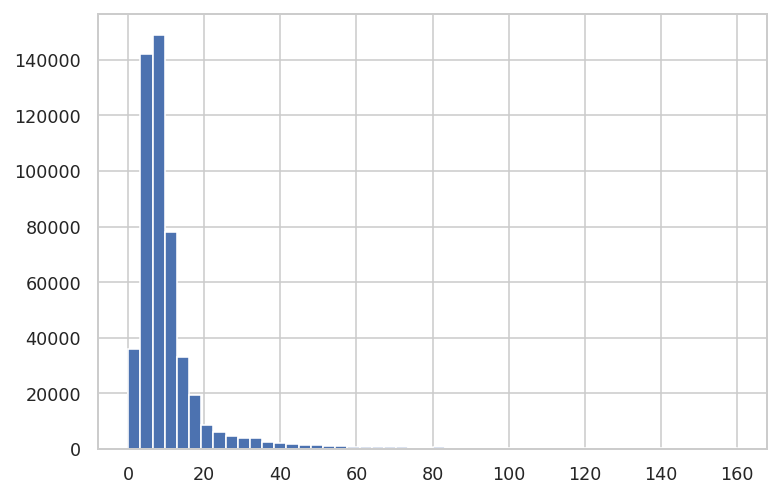

In [14]:
plt.hist(missing, bins=50) ;

Sanity check:

In [15]:
(raw_data.isnull().sum(axis=1) == missing).all()

True

## African and non-African individuals

In [16]:
afr_individuals = [name for (name, data) in individuals.items() if data['Region'] == 'Africa' and data['Genetic sex assignment'] == 'XY']
nonafr_individuals = [name for (name, data) in individuals.items() if data['Region'] != 'Africa' and data['Genetic sex assignment'] == 'XY']

In [17]:
len(afr_individuals + nonafr_individuals)

162

## Find derived variants fixed in humans

In [18]:
is_fixed_humans = raw_data.apply(lambda row: row.sum() == (~row.isnull()).sum(), axis=1)

## Count fixed derived sites

In [19]:
fixed_sites = DataFrame(dict(fixed=raw_data.loc[is_fixed_humans].index.values))
fixed_sites['start'] = fixed_sites.fixed // 100000 * 100000
fixed_sites['end'] = fixed_sites.start + 100000
fixed_sites_windows = fixed_sites.groupby(['start', 'end']).count().reset_index()
fixed_sites_windows.head()

,start,end,fixed
0,400000,500000,1
1,500000,600000,1
2,1200000,1300000,5
3,2300000,2400000,3
4,2400000,2500000,8


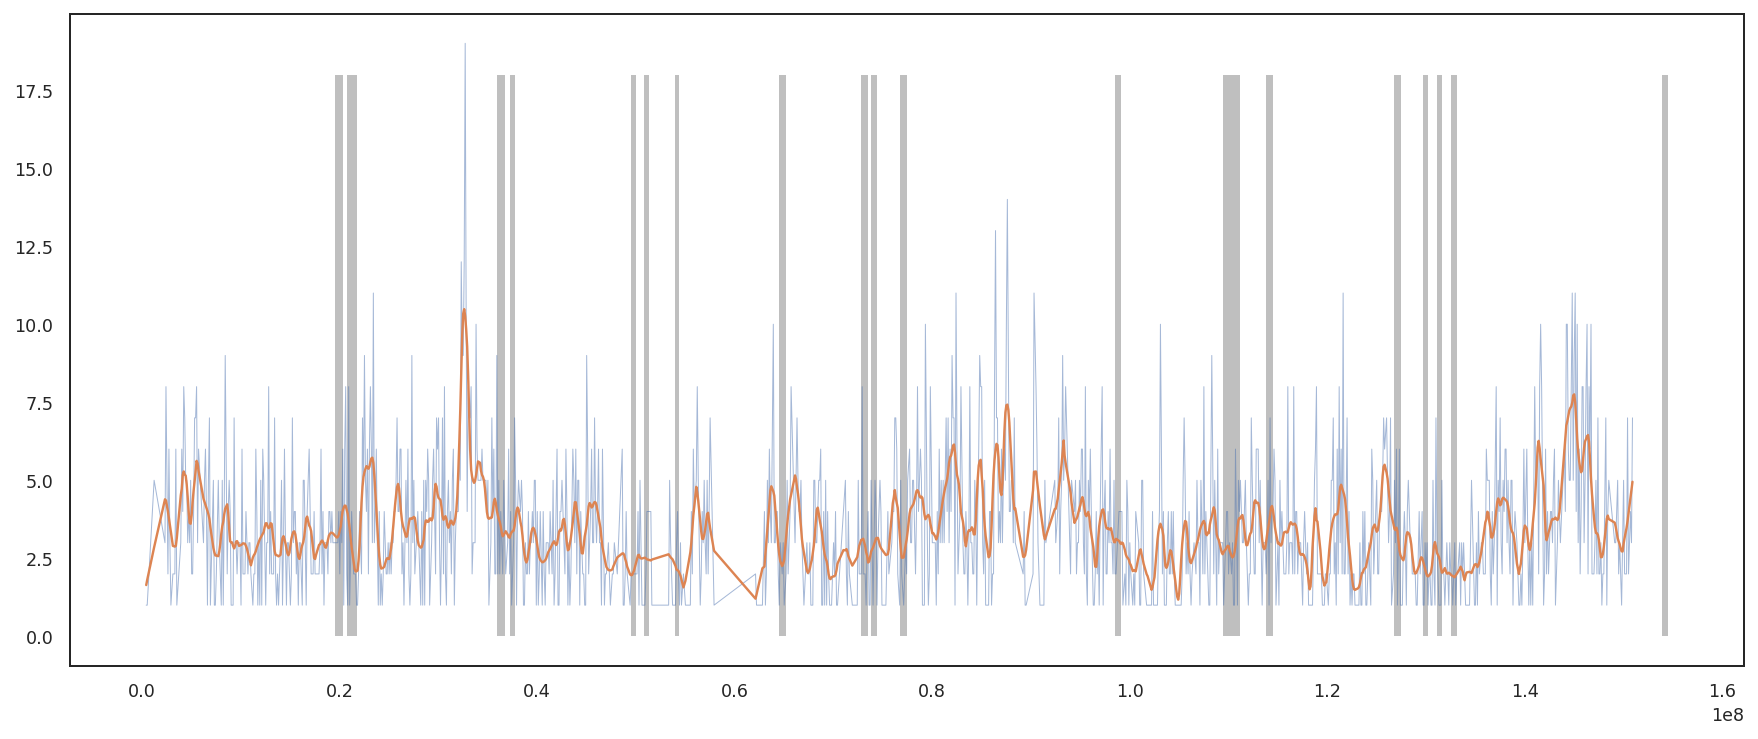

In [21]:
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 1, figsize=(15, 6))

    p = ax.plot(fixed_sites_windows.start, fixed_sites_windows.fixed, linewidth=0.5, alpha=0.5)
    
    for tup in extended_peak_regions_75.itertuples():
        g = ax.add_patch(Rectangle((tup.start_pos, 0), tup.end_pos-tup.start_pos, 18, 
                     facecolor='gray',
                     linewidth=0,
                     alpha=0.5,
                     zorder=0))
    
    fit = lowess(fixed_sites_windows.fixed, fixed_sites_windows.start, is_sorted=True, frac=0.01, it=0)
    ax.plot(fit[:,0], fit[:,1])


Inside and outside 75% swept regions

In [22]:
def get_overlapping(df):
    s, e = df.start_pos.iloc[0], df.end_pos.iloc[0]
    return fixed_sites_windows.loc[lambda df: (df.start >= s) & (df.end <= e)]

overlapping = (extended_peak_regions_75.loc[lambda df: df.prop_swept >= 0.5]
           .groupby(['pos', 'prop_swept']).apply(get_overlapping).reset_index()
          )['fixed']

nonoverlapping = fixed_sites_windows.loc[fixed_sites_windows.index.difference(overlapping.index), 'fixed']

print('mean count overlapping:', overlapping.mean())
print('mean count non nonoverlapping:', nonoverlapping.mean())
print(scipy.stats.ttest_ind(overlapping, nonoverlapping))#loc[lambda sr: ~sr.isnull()], sr.loc[lambda sr: ~sr.isnull()]))

mean count overlapping: 2.8051948051948052
mean count non nonoverlapping: 3.5030728709394205
Ttest_indResult(statistic=-2.686451801685209, pvalue=0.007320098262263125)


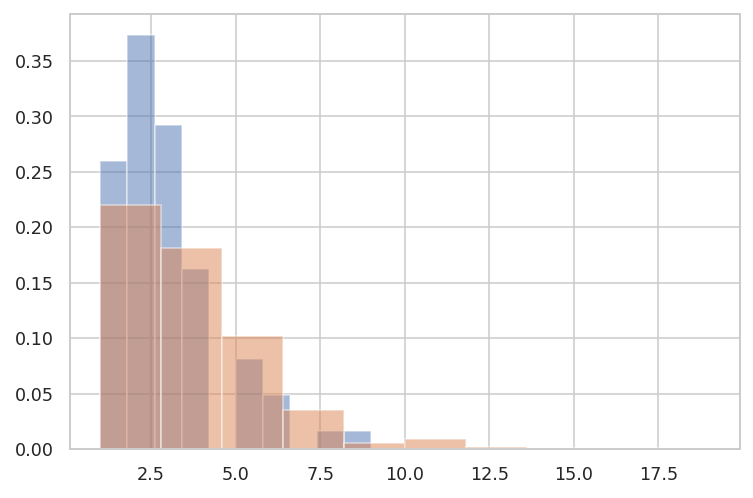

In [23]:
plt.hist(overlapping, label='swept', density=True, alpha=0.5)
plt.hist(nonoverlapping, label='swept', density=True, alpha=0.5) ;

Not any substantial difference it seems. Makes sense. Any recurrent sweeps should not increase substitution rate on the single lineage to chimps.

## Subset sfs data into Africans and non-Africans

We only include sites that segregate in humans.

In [24]:
afr_genotypes = raw_data.loc[~is_fixed_humans, afr_individuals]
nonafr_genotypes = raw_data.loc[~is_fixed_humans, nonafr_individuals]

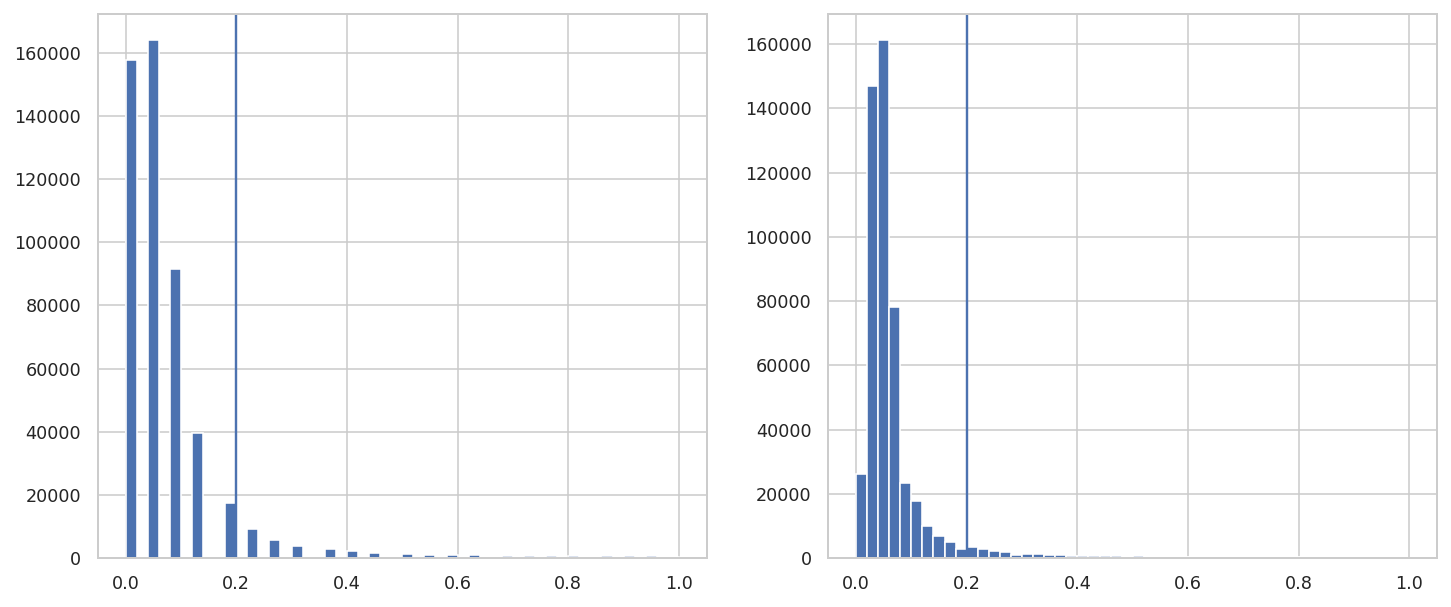

In [25]:
afr_missing = afr_genotypes.isnull().sum(axis=1) / len(afr_individuals)
nonafr_missing = nonafr_genotypes.isnull().sum(axis=1) / len(nonafr_individuals)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.hist(afr_missing, bins=50)
ax1.axvline(x=0.2)
ax2.hist(nonafr_missing, bins=50)
ax2.axvline(x=0.2) ;

## Compute freqs for each SNP

In [26]:
afr_genotypes_filt = afr_genotypes.loc[afr_missing < 0.2]
afr_sfs_data = afr_genotypes_filt.apply(lambda sr: sr.sum() / (~sr.isnull()).sum(), axis=1 )
afr_sfs_data.index.name = 'pos'
afr_sfs_data.head()

pos
1254456    0.045455
2419650    0.000000
2419678    0.000000
2701632    0.000000
2701845    0.000000
dtype: float64

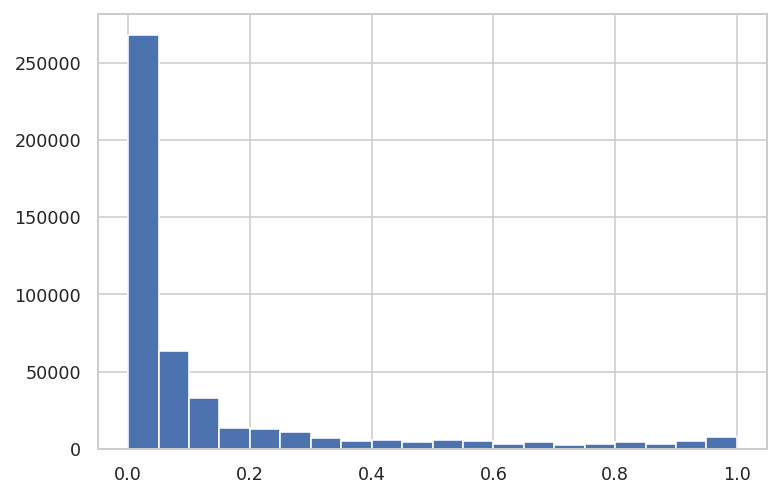

In [27]:
plt.hist(afr_sfs_data, bins=20) ;

In [28]:
nonafr_genotypes_filt = nonafr_genotypes.loc[nonafr_missing < 0.2]
nonafr_sfs_data = nonafr_genotypes_filt.apply(lambda sr: sr.sum() / (~sr.isnull()).sum(), axis=1 )
nonafr_sfs_data.index.name = 'pos'
nonafr_sfs_data.head()

pos
1254456    0.000000
2419158    0.000000
2419650    0.008696
2419678    0.033613
2420392    0.194690
dtype: float64

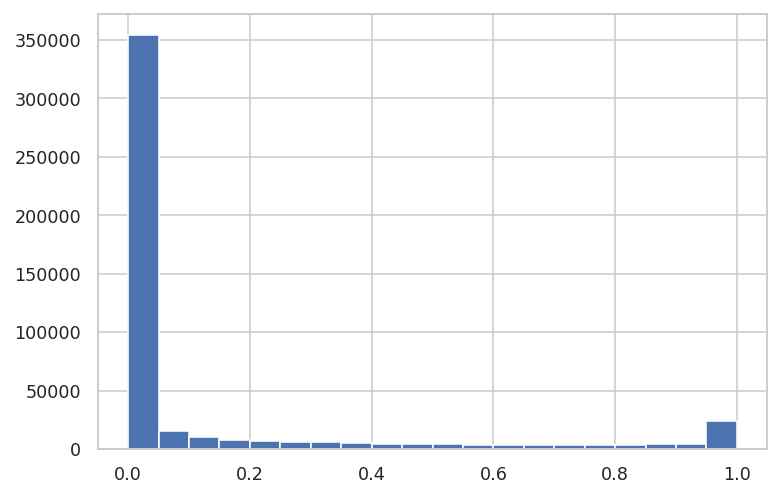

In [29]:
plt.hist(nonafr_sfs_data, bins=20) ;

In [30]:
# mask = ((afr_sfs_data == 1) & (nonafr_sfs_data == 1)) # aligns on index
# fixed_in_humans = mask.loc[mask].index.values
# afr_sfs_data.index.isin(mask)

# Other plan: why not make is simpler: not do freq bins and the count them, but just keep the freqs and then mean over them.

In [56]:
afr_derived_freqs = afr_sfs_data.reset_index(name='freq')
afr_derived_freqs['start'] = afr_derived_freqs.pos // 100000 * 100000
afr_derived_freqs['end'] = afr_derived_freqs.start + 100000
afr_derived_freqs = afr_derived_freqs.loc[afr_derived_freqs.freq > 0]

nonafr_derived_freqs = nonafr_sfs_data.reset_index(name='freq')
nonafr_derived_freqs['start'] = nonafr_derived_freqs.pos // 100000 * 100000
nonafr_derived_freqs['end'] = nonafr_derived_freqs.start + 100000
nonafr_derived_freqs = nonafr_derived_freqs.loc[nonafr_derived_freqs.freq > 0]

derived_freqs = pd.concat([afr_derived_freqs.assign(region='Africa'),
                                 nonafr_derived_freqs.assign(region='nonAfrica')])
derived_freqs.head()

,pos,freq,start,end,region
0,1254456,0.045455,1200000,1300000,Africa
5,2701938,0.950000,2700000,2800000,Africa
6,2702143,0.200000,2700000,2800000,Africa
8,2702339,0.863636,2700000,2800000,Africa
9,2702698,0.181818,2700000,2800000,Africa


In [68]:
min_freq = 0.25
nonafr_derived_window_freqs = (derived_freqs
                        .loc[(derived_freqs.region == 'nonAfrica') & (derived_freqs.freq > min_freq)]
                        .groupby(['region', 'start', 'end'])
                        .freq
                        .agg(['mean', 'count'])
                        .reset_index()
                        .rename(columns={'mean': 'mean_freq', 'count': 'nr_snps'})
                       )
nonafr_derived_window_freqs.head()

,region,start,end,mean_freq,nr_snps
0,nonAfrica,2700000,2800000,0.611470,103
1,nonAfrica,2800000,2900000,0.729443,78
2,nonAfrica,2900000,3000000,0.907019,29
3,nonAfrica,3000000,3100000,0.563920,89
4,nonAfrica,3100000,3200000,0.533957,137


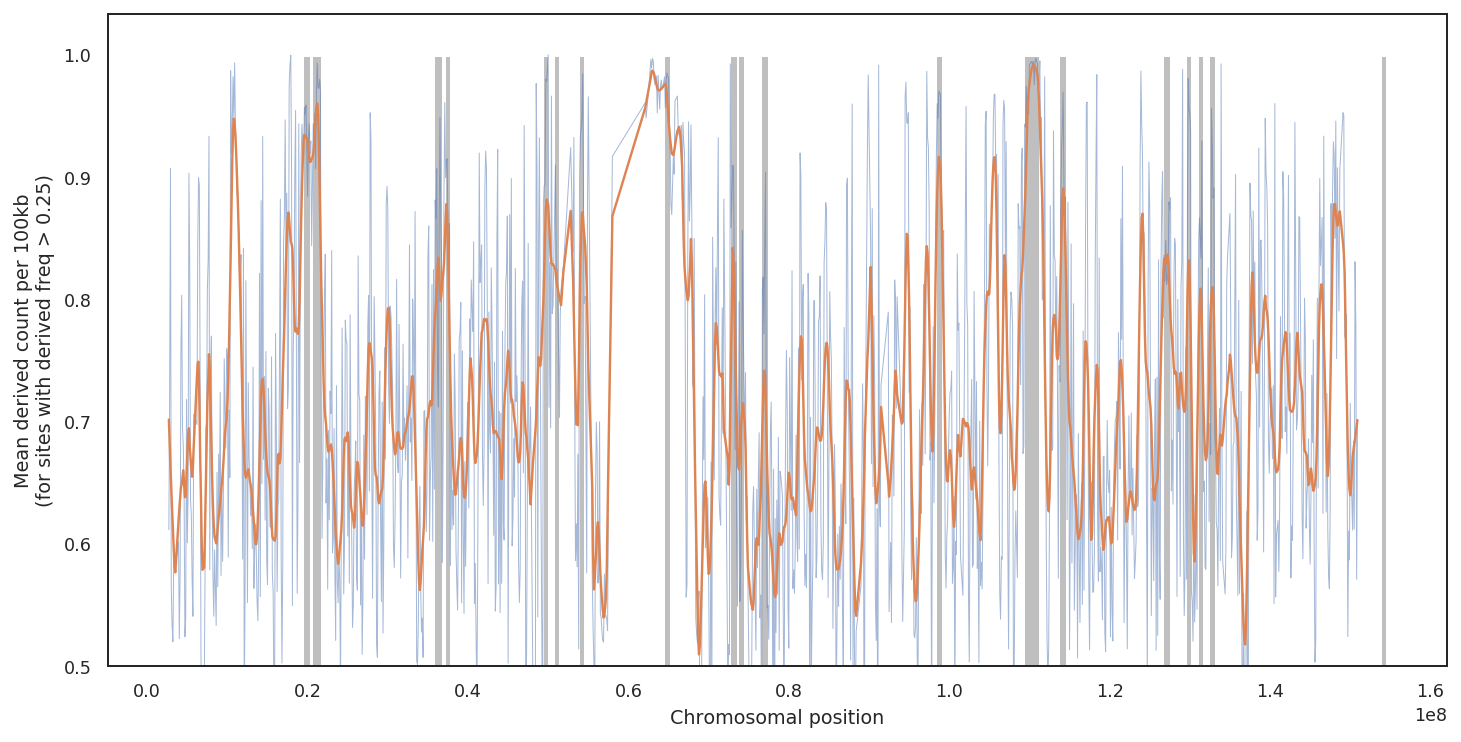

In [69]:
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))

    p = ax.plot(nonafr_derived_window_freqs.start, nonafr_derived_window_freqs.mean_freq, linewidth=0.5, alpha=0.5)

    for tup in extended_peak_regions_75.itertuples():
        base = 0.5
        g = ax.add_patch(Rectangle((tup.start_pos, base), tup.end_pos-tup.start_pos, plot_df.mean_freq.max()-base, 
                     facecolor='gray',
                     linewidth=0,
                     alpha=0.5,
                     zorder=0))
    ax.set_ylim(bottom=base)
        
    fit = lowess(nonafr_derived_window_freqs.mean_freq, nonafr_derived_window_freqs.start, is_sorted=True, frac=0.01, it=0)
    ax.plot(fit[:,0], fit[:,1])
        
#     ax.fill_between(plot_df.start, plot_df.mean_freq, plot_df.mean_freq.max(),
#                     interpolate=False, color=p[-1].get_color(), alpha=0.2)
    ax.set_xlabel("Chromosomal position")
    ax.set_ylabel("Mean derived count per 100kb\n(for sites with derived freq > {})".format(min_freq))

## Compute SFS in windows

Frequencies for each SNP along with start and frequency bin:

In [70]:
# bins = np.linspace(0, 1, 100)

In [71]:
# afr_derived_freqs = afr_sfs_data.reset_index(name='freq')
# binned_freqs, afr_freq_bins = pd.cut(afr_derived_freqs.freq, bins=bins, retbins=True, include_lowest=True)
# afr_derived_freqs['freq_bin'] = binned_freqs
# afr_derived_freqs['start'] = afr_derived_freqs.pos // 100000 * 100000
# afr_derived_freqs = afr_derived_freqs.loc[afr_derived_freqs.freq > 0]
# afr_derived_freqs.head()

In [72]:
# nonafr_derived_freqs = nonafr_sfs_data.reset_index(name='freq')
# binned_freqs, non_afr_freq_bins = pd.cut(nonafr_derived_freqs.freq, bins=bins, retbins=True, include_lowest=True)
# nonafr_derived_freqs['freq_bin'] = binned_freqs
# nonafr_derived_freqs['start'] = nonafr_derived_freqs.pos // 100000 * 100000
# nonafr_derived_freqs = nonafr_derived_freqs.loc[nonafr_derived_freqs.freq > 0]
# nonafr_derived_freqs.head()

## Make table of how many sites are in each frequency bin

In [73]:
# # A table with all starts and frequency bins and default counts of zero SNPs in each window:
# unique_freq_bins = binned_freqs.unique().sort_values()
# starts = list(range(0, nonafr_derived_freqs.pos.max() // 100000 * 100000 + 100000, 100000))

In [74]:
# df = pd.DataFrame(list(itertools.product(starts,unique_freq_bins)), columns=['start','freq_bin'])
# df['nr_snps'] = 0
# df.set_index(['start', 'freq_bin'], inplace=True)
# # Fill in non-zero counts:
# counts = afr_derived_freqs.groupby(['start','freq_bin']).size()
# df['nr_snps'] = counts
# df['nr_snps'].fillna(0, inplace=True)
# df.reset_index(inplace=True)
# # Add mean freqs for each bin:
# mean_bin_freqs = afr_derived_freqs.groupby(['freq_bin']).freq.mean().reset_index(name='mean_bin_freq')
# afr_derived_window_freqs = df.merge(mean_bin_freqs, on='freq_bin', how='left')
# # Add end
# afr_derived_window_freqs['end'] = afr_derived_window_freqs.start + 100000
# afr_derived_window_freqs.head()

In [75]:
# df = pd.DataFrame(list(itertools.product(starts,unique_freq_bins)), columns=['start','freq_bin'])
# df['nr_snps'] = 0
# df.set_index(['start', 'freq_bin'], inplace=True)
# # Fill in non-zero counts:
# counts = nonafr_derived_freqs.groupby(['start','freq_bin']).size()
# df['nr_snps'] = counts
# df['nr_snps'].fillna(0, inplace=True)
# df.reset_index(inplace=True)
# # Add mean freqs for each bin:
# mean_bin_freqs = nonafr_derived_freqs.groupby(['freq_bin']).freq.mean().reset_index(name='mean_bin_freq')
# nonafr_derived_window_freqs = df.merge(mean_bin_freqs, on='freq_bin', how='left')
# # Add end
# nonafr_derived_window_freqs['end'] = nonafr_derived_window_freqs.start + 100000
# nonafr_derived_window_freqs.head()

In [76]:
# afr_derived_window_freqs
# derived_window_freqs = pd.concat([afr_derived_window_freqs.assign(region='Africa'), 
#                                  nonafr_derived_window_freqs.assign(region='nonAfrica')])
# derived_window_freqs.head()

We only look at windows with at least this number of derived variants:

In [77]:
# min_freq = 0.25

In [78]:
# plot_df = (derived_window_freqs.loc[(derived_window_freqs.region == 'nonAfrica') & \
#                                   (derived_window_freqs['mean_bin_freq'] >= min_freq) & \
#                                   (derived_window_freqs['nr_snps'] > 0)]
#            .groupby(['region', 'start', 'end'])
#             .apply(lambda df: (df.mean_bin_freq * df.nr_snps).sum() / df.nr_snps.sum())
#            .to_frame('mean_freq')
#            .reset_index()
#           )


In [79]:
# with sns.axes_style('white'):
#     fig, ax = plt.subplots(1, 1, figsize=(12, 6))
# #    ax.scatter(mean_derived_counts.start, mean_derived_counts.mean_count)

#     p = ax.plot(plot_df.start, plot_df.mean_freq, linewidth=0.5, alpha=0.5)

#     for tup in extended_peak_regions_75.itertuples():
#         base = 0.5
#         g = ax.add_patch(Rectangle((tup.start_pos, base), tup.end_pos-tup.start_pos, plot_df.mean_freq.max()-base, 
#                      facecolor='gray',
#                      linewidth=0,
#                      alpha=0.5,
#                      zorder=0))
#     ax.set_ylim(bottom=base)
        
#     fit = lowess(plot_df.mean_freq, plot_df.start, is_sorted=True, frac=0.01, it=0)
#     ax.plot(fit[:,0], fit[:,1])
        
# #     ax.fill_between(plot_df.start, plot_df.mean_freq, plot_df.mean_freq.max(),
# #                     interpolate=False, color=p[-1].get_color(), alpha=0.2)
#     ax.set_xlabel("Chromosomal position")
#     ax.set_ylabel("Mean derived count per 100kb\n(for sites with derived freq > {})".format(min_freq))

In [80]:
# def mean_freq(df):
#     num = (df.mean_bin_freq * df.nr_snps).sum()
#     denom = df.nr_snps.sum()
#     if denom:
#         return num / denom
#     else:
#         return np.nan

# mean_derived_window_freqs = (derived_window_freqs
#                              .loc[(derived_window_freqs['mean_bin_freq'] >= min_freq) \
#                                  & (derived_window_freqs['nr_snps'] > 0)]
#            .groupby(['region', 'start', 'end'])
#            .apply(mean_freq)
#            .to_frame('mean_freq')
#            .reset_index()
#           )
# mean_derived_window_freqs.head()

## Inside and outside 75% swept regions

In [85]:
def get_overlapping(df):
    s, e = df.start_pos.iloc[0], df.end_pos.iloc[0]
    return nonafr_derived_window_freqs.loc[lambda df: (df.start >= s) & (df.end <= e)]

overlapping = (extended_peak_regions_75.loc[lambda df: df.prop_swept >= 0.5]
           .groupby(['pos', 'prop_swept']).apply(get_overlapping).reset_index()
          )

nonoverlapping = nonafr_derived_window_freqs.loc[fixed_sites_windows.index.difference(overlapping.index)]

print('mean count overlapping:', overlapping.mean_freq.mean())
print('mean count non nonoverlapping:', nonoverlapping.mean_freq.mean())
print(scipy.stats.ttest_ind(overlapping.mean_freq, nonoverlapping.mean_freq))#loc[lambda sr: ~sr.isnull()], sr.loc[lambda sr: ~sr.isnull()]))

mean count overlapping: 0.9177257970992667
mean count non nonoverlapping: 0.7208884550970027
Ttest_indResult(statistic=12.247465252134194, pvalue=1.332293977355709e-32)


In [86]:
# non_afr_mean_derived_window_freqs = mean_derived_window_freqs.loc[mean_derived_window_freqs.region == 'Africa']

# def get_overlapping(df):
#     s, e = df.start_pos.iloc[0], df.end_pos.iloc[0]
#     return nonafr_derived_window_freqs.loc[lambda df: (df.start >= s) & (df.end <= e)]

# sr = (extended_peak_regions_75.loc[lambda df: df.prop_swept >= 0.5]
#            .groupby(['pos', 'prop_swept']).apply(get_overlapping).reset_index()
#           )['mean_freq']

# print('mean count:', nonafr_derived_window_freqs.mean_freq.mean())
# print('mean count all extended swept regions:', sr.mean())
# print(scipy.stats.ttest_ind(non_afr_mean_derived_window_freqs.mean_freq.loc[lambda sr: ~sr.isnull()], sr.loc[lambda sr: ~sr.isnull()]))

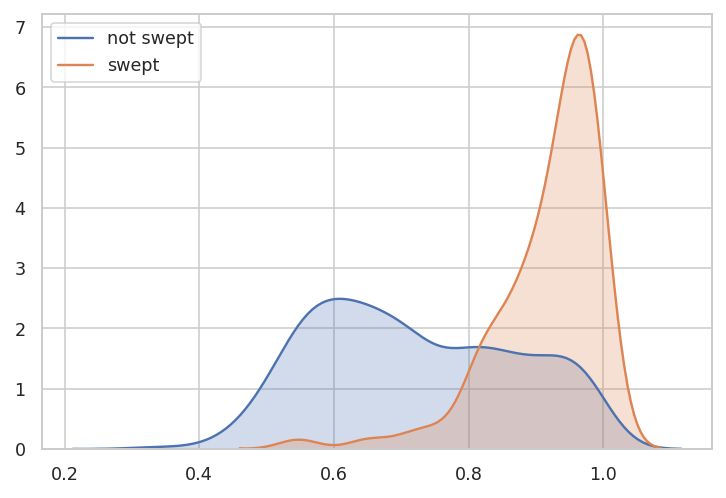

In [89]:
sns.kdeplot(nonoverlapping.mean_freq, shade=True, label='not swept')
sns.kdeplot(overlapping.mean_freq, shade=True, label='swept');

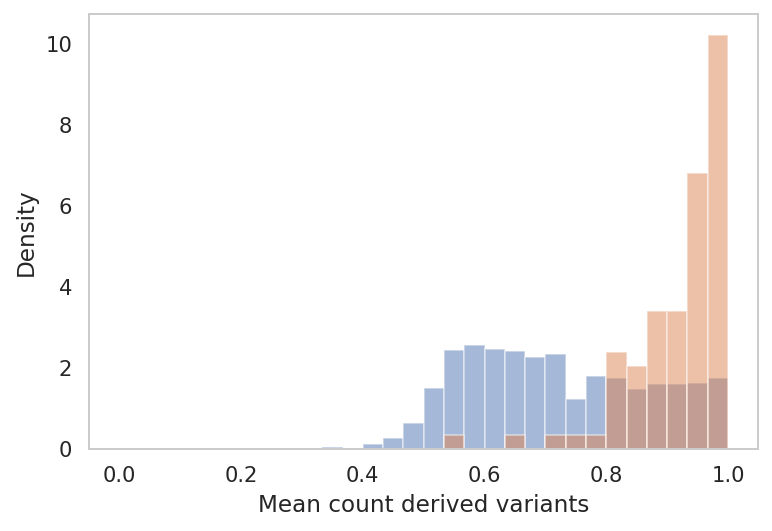

In [91]:
with sns.plotting_context('paper', font_scale=1.2):
    with sns.axes_style("whitegrid", {'axes.grid' : False}):
        plt.hist(nonoverlapping.mean_freq, label='not swept', 
                 density=True, alpha=0.5, bins=np.linspace(0, 1, 31))
        plt.hist(overlapping.mean_freq, label='swept', 
                 density=True, alpha=0.5, bins=np.linspace(0, 1, 31));
        plt.xlabel("Mean count derived variants")
        plt.ylabel("Density")
        
        plt.savefig(str(ag.figures_dir / 'derived_in_75%_region.pdf')) 

## Load sweep data

In [92]:
sweep_data = pd.read_hdf(ag.results_dir / 'sweep_data.hdf').loc[lambda df: df.not_missing]

## On individual swept haplotypes

In [93]:
df = nonafr_genotypes.rename_axis('pos').reset_index().melt(id_vars='pos', var_name='indiv_1', value_name='is_derived')
df['start'] = (df.pos // 100000) * 100000
df.head()

,pos,indiv_1,is_derived,start
0,399490,B_Karitiana-3,NaN,300000
1,399586,B_Karitiana-3,0.0,300000
2,399824,B_Karitiana-3,NaN,300000
3,399834,B_Karitiana-3,0.0,300000
4,399856,B_Karitiana-3,NaN,300000


Compute for non-Africans, for positions with derived count above cutoff, the proportion of positions in a window where an individual has the derived variant.

In [ ]:
def filt(df):
    num = df.is_derived.sum()
    denom = (~df.is_derived.isnull()).sum()
    return denom > 0 and num / denom > min_freq
    
def stats(df):
    num = df.is_derived.sum()
    denom = (~df.is_derived.isnull()).sum()
    if denom > 0:
        ratio = num / denom
    else:
        ratio = np.nan
    return pd.Series([num, denom, ratio], index=['nr_derived', 'nr_total', 'prop_deriv'])
    
derived_windows = (df
            .groupby('pos')
            .filter(filt)
            .groupby(['indiv_1', 'start'])
            .apply(stats)
            .reset_index()
           )
derived_windows.head(3)

In [ ]:
merged_data = derived_windows.merge(sweep_data, on=['indiv_1', 'start'], how='left')

In [ ]:
merged_data.head(3)

In [ ]:
sns.kdeplot(merged_data.loc[merged_data.swept == False].prop_deriv, shade=True, label='not swept')
sns.kdeplot(merged_data.loc[merged_data.swept == True].prop_deriv, shade=True, label='swept');

In [ ]:
with sns.plotting_context('paper', font_scale=1.2):
    with sns.axes_style("whitegrid", {'axes.grid' : False}):
        plt.hist(merged_data.loc[merged_data.swept == False].prop_deriv, label='not swept', 
                 density=True, alpha=0.5, bins=np.linspace(0, 1, 51))
        plt.hist(merged_data.loc[merged_data.swept == True].prop_deriv, label='swept', 
                 density=True, alpha=0.5, bins=np.linspace(0, 1, 51))
        plt.xlabel("Derived proportion")
        plt.ylabel("Density")

        plt.savefig(str(ag.figures_dir / 'derived.pdf')) 

In [ ]:
merged_data.groupby(['swept']).prop_deriv.agg(['mean', 'median', 'sem'])

In [ ]:
scipy.stats.mannwhitneyu(merged_data.loc[merged_data.swept == True].prop_deriv,
                         merged_data.loc[merged_data.swept == False].prop_deriv, alternative='two-sided')

In [ ]:
merged_data['clade_size_group'] = pd.cut(merged_data.clade_size, np.linspace(0, 120, 13))

list(merged_data.clade_size_group.unique().sort_values())

In [ ]:
for cut in merged_data.clade_size_group.unique().sort_values():
    sns.kdeplot(merged_data.loc[(merged_data.clade_size_group == cut)].prop_deriv, shade=True);


In [ ]:
merged_data['clade_size_group'] = pd.cut(merged_data.clade_size, np.linspace(0, 120, 13), right=False)

grid = sns.FacetGrid(merged_data, col='clade_size_group', aspect=2, height=2, sharey=False, col_wrap=3)
grid.map(plt.hist, 'prop_deriv', density=True, bins=np.linspace(0, 1, 100)) ;

------

## Read Mois table with SFS info for coparison

In [89]:
derived_counts = pd.read_table('~/simons/faststorage/people/moi/X_chrom_Kasper/out/derived_alleles_pol_in_humans/sfs.txt', 
                   names=["pop", "start", "end", "der", "counts"])
derived_counts.head()

,pop,start,end,der,counts
0,NonAfricans,1200000,1300000,0,1
1,NonAfricans,1200000,1300000,1,0
2,NonAfricans,1200000,1300000,2,0
3,NonAfricans,1200000,1300000,3,0
4,NonAfricans,1200000,1300000,4,0


Mean count of derived variants

Only at sites with at least some number of derived variants:

In [115]:
min_der = 20

mean_derived_counts = (derived_counts
           .loc[(derived_counts['der'] > min_der) & (derived_counts['counts'] > 0) & \
                (derived_counts['pop'] == "NonAfricans")]
           .groupby(['pop', 'start', 'end'])
           .apply(lambda df: (df.der * df.counts).sum() / df.counts.sum())
           .to_frame('mean_count')
           .reset_index()
          )

In [116]:
mean_derived_counts.head()

,pop,start,end,mean_count
0,NonAfricans,2700000,2800000,63.884615
1,NonAfricans,2800000,2900000,72.333333
2,NonAfricans,2900000,3000000,95.521739
3,NonAfricans,3000000,3100000,56.337838
4,NonAfricans,3100000,3200000,53.290541


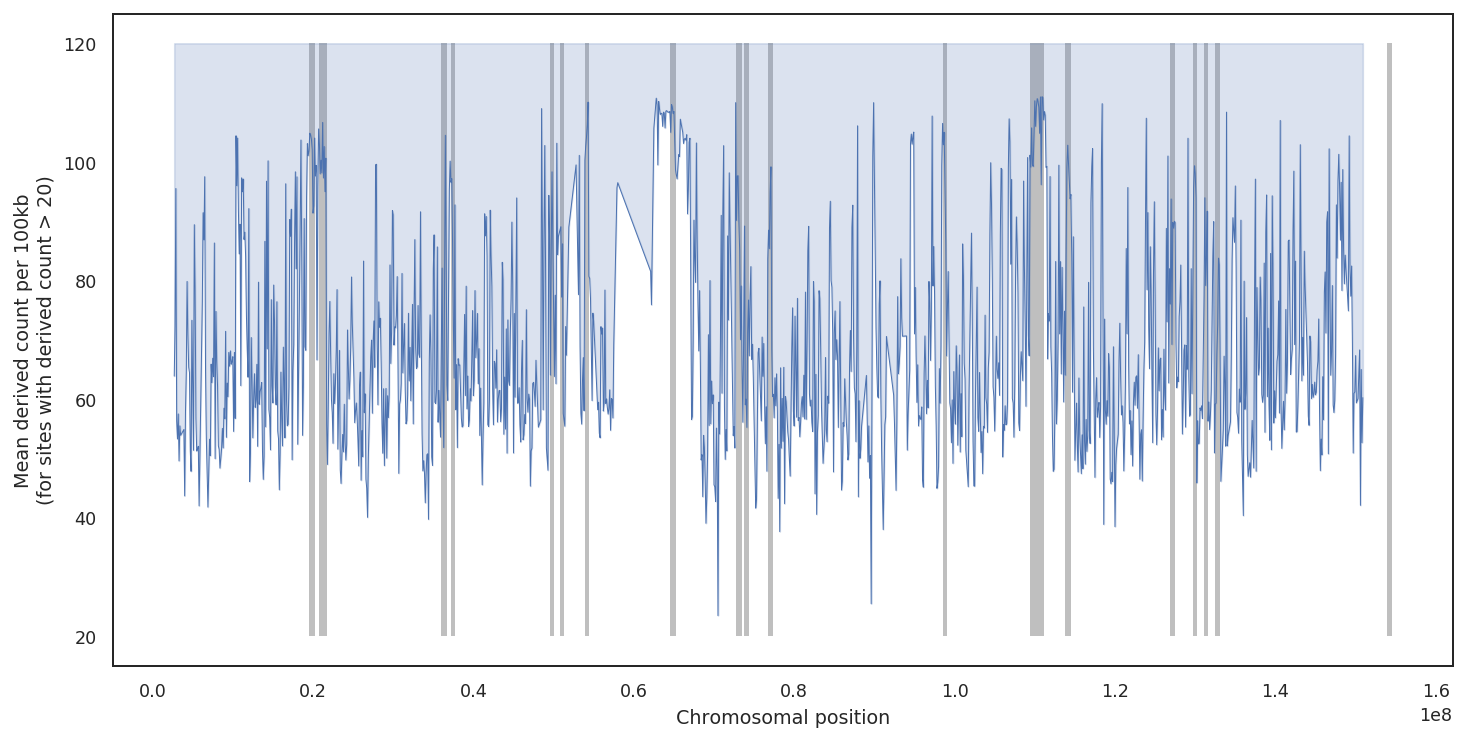

In [117]:
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
#    ax.scatter(mean_derived_counts.start, mean_derived_counts.mean_count)
    p = ax.plot(mean_derived_counts.start, mean_derived_counts.mean_count, linewidth=0.5)

    for tup in extended_peak_regions_75.itertuples():
        g = ax.add_patch(Rectangle((tup.start_pos, min_der), tup.end_pos-tup.start_pos, 120-min_der, 
                     facecolor='gray',
                     linewidth=0,
                     alpha=0.5,
                     zorder=0))

    ax.fill_between(mean_derived_counts.start, mean_derived_counts.mean_count, 120,
                    interpolate=False, color=p[-1].get_color(), alpha=0.2)
    ax.set_xlabel("Chromosomal position")
    ax.set_ylabel("Mean derived count per 100kb\n(for sites with derived count > {})".format(min_der))

## Inside and outside 75% swept regions

In [118]:
def get_overlapping(df):
    s, e = df.start_pos.iloc[0], df.end_pos.iloc[0]
    return mean_derived_counts.loc[lambda df: (df.start >= s) & (df.end <= e)]

sr = (extended_peak_regions_75.loc[lambda df: df.prop_swept >= 0.5]
           .groupby(['pos', 'prop_swept']).apply(get_overlapping).reset_index()
          )['mean_count']

print('mean count:', mean_derived_counts.mean_count.mean())
print('mean count all extended swept regions:', sr.mean())
print(scipy.stats.ttest_ind(mean_derived_counts.mean_count.loc[lambda sr: ~sr.isnull()], sr.loc[lambda sr: ~sr.isnull()]))

mean count: 69.41994697352538
mean count all extended swept regions: 94.65991278430262
Ttest_indResult(statistic=-13.262278074638827, pvalue=6.239948953523074e-38)


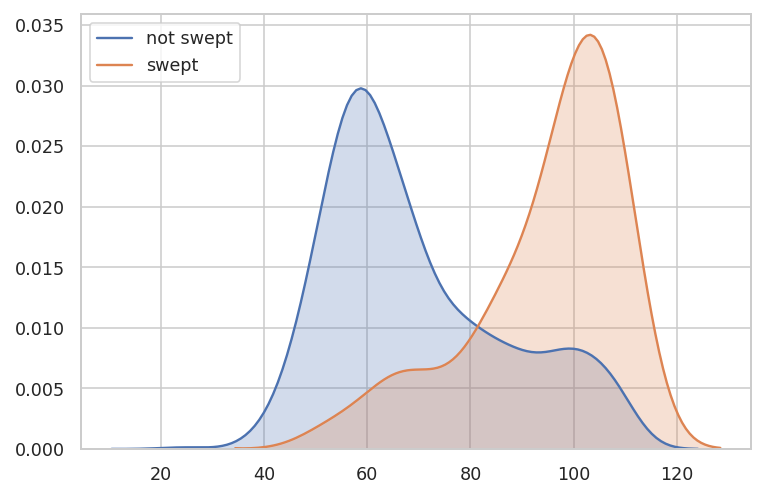

In [119]:
sns.kdeplot(mean_derived_counts.mean_count.loc[lambda sr: ~sr.isnull()], shade=True, label='not swept')
sns.kdeplot(sr.loc[lambda sr: ~sr.isnull()], shade=True, label='swept');

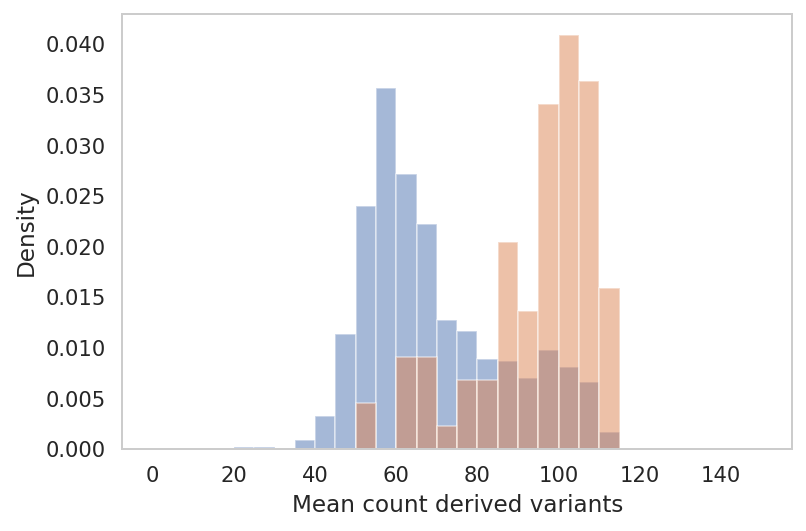

In [120]:
with sns.plotting_context('paper', font_scale=1.2):
    with sns.axes_style("whitegrid", {'axes.grid' : False}):
        plt.hist(mean_derived_counts.mean_count.loc[lambda sr: ~sr.isnull()], label='not swept', 
                 density=True, alpha=0.5, bins=np.linspace(0, 150, 31))
        plt.hist(sr.loc[lambda sr: ~sr.isnull()], label='swept', 
                 density=True, alpha=0.5, bins=np.linspace(0, 150, 31));
        plt.xlabel("Mean count derived variants")
        plt.ylabel("Density")
        
        plt.savefig(str(ag.figures_dir / 'derived_in_75%_region.pdf')) 

## Load sweep data

In [29]:
sweep_data = pd.read_hdf(ag.results_dir / 'sweep_data.hdf').loc[lambda df: df.not_missing]

## On individual swept haplotypes

In [30]:
moi_dir = '/project/simons/faststorage/people/moi/X_chrom_Kasper/out/derived_alleles_pol_in_humans/'

with open(moi_dir + 'derived_X.geno') as f:
    arr = np.array([list(line.strip()) for line in f])

arr = np.where(arr == '.', np.nan, arr).astype(float)  

with open(moi_dir + 'derived_X.inds') as f:
    indivs = f.read().split()

with open(moi_dir + 'derived_X.snps') as f:
    snp_pos = map(int, f.read().split())

sr = DataFrame(arr, columns=indivs, index=snp_pos).stack()#.to_frame('is_derived').reset_index().

sr.index.set_names(['pos', 'indiv_1'], inplace=True)
df = sr.to_frame('is_derived').reset_index()

df['start'] = (df.pos // 100000) * 100000
df.head(3)

,pos,indiv_1,is_derived,start
0,399490,S_Spanish-1,0.0,300000
1,399490,B_French-3,0.0,300000
2,399490,S_Papuan-5,0.0,300000


Compute for non-Africans, for positions with derived count above cutoff, the proportion of positions in a window where an individual has the derived variant.

In [31]:
derived_windows = (df
            .loc[~df.indiv_1.isin(regions['Africa'])]
            .groupby('pos')
            .filter(lambda df: df.is_derived.sum() > min_der)
            .groupby(['indiv_1', 'start'])
            .apply(lambda df: pd.Series([df.is_derived.sum(), 
                                         df.is_derived.size, 
                                         df.is_derived.sum() / df.is_derived.size], 
                                         index=['nr_derived', 'nr_total', 'prop_deriv'])
                   )
            .reset_index()
           )
derived_windows.head(3)

,indiv_1,start,nr_derived,nr_total,prop_deriv
0,B_Australian-4,400000,1.0,3.0,0.333333
1,B_Australian-4,500000,1.0,1.0,1.000000
2,B_Australian-4,1200000,4.0,6.0,0.666667


In [32]:
sweep_data = pd.read_hdf(ag.results_dir / 'sweep_data.hdf')

In [33]:
merged_data = derived_windows.merge(sweep_data, on=['indiv_1', 'start'], how='left')

In [34]:
merged_data.head(3)

,indiv_1,start,nr_derived,nr_total,prop_deriv,end,pop_1,region_label_1,region_id_1,region_1,...,swept_af,not_missing,never_swept,never_swept_af,never_win_swept,never_win_swept_af,conserv_swept_group,conserv_swept_group_af,partial_sweep_win,partial_sweep_win_af
0,B_Australian-4,400000,1.0,3.0,0.333333,500000,Australian,Oceania,4,Oceania,...,False,False,True,True,True,True,ambig,ambig,False,False
1,B_Australian-4,500000,1.0,1.0,1.000000,600000,Australian,Oceania,4,Oceania,...,False,False,True,True,True,True,ambig,ambig,False,False
2,B_Australian-4,1200000,4.0,6.0,0.666667,1300000,Australian,Oceania,4,Oceania,...,False,False,True,True,True,True,ambig,ambig,False,False


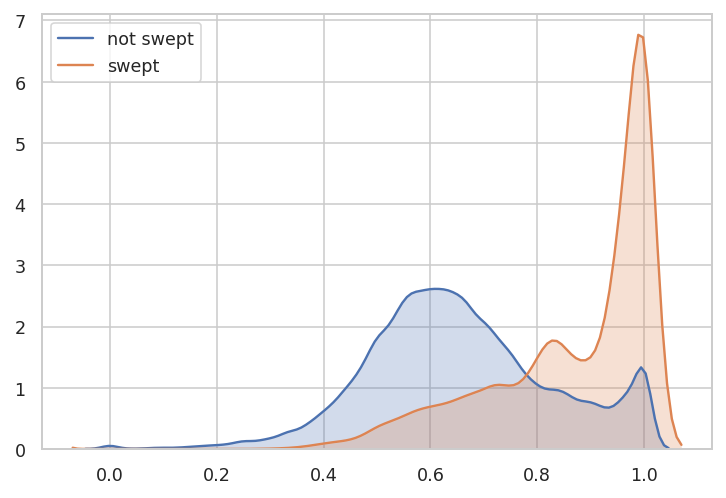

In [35]:
sns.kdeplot(merged_data.loc[merged_data.swept == False].prop_deriv, shade=True, label='not swept')
sns.kdeplot(merged_data.loc[merged_data.swept == True].prop_deriv, shade=True, label='swept');

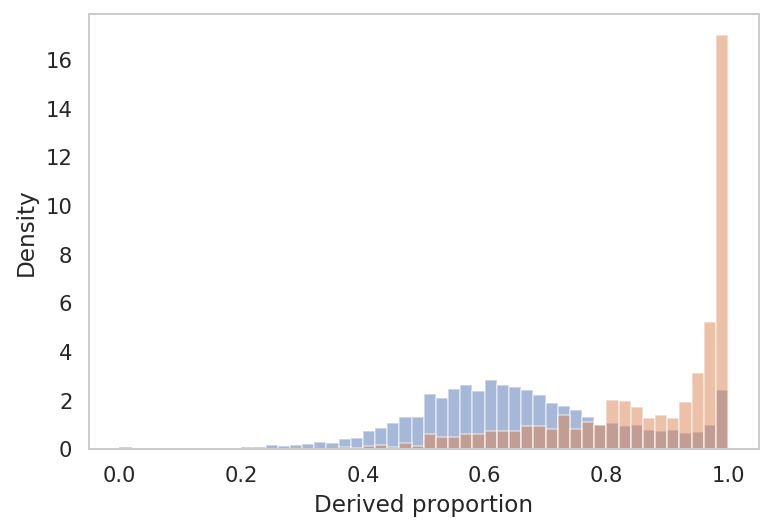

In [36]:
with sns.plotting_context('paper', font_scale=1.2):
    with sns.axes_style("whitegrid", {'axes.grid' : False}):
        plt.hist(merged_data.loc[merged_data.swept == False].prop_deriv, label='not swept', 
                 density=True, alpha=0.5, bins=np.linspace(0, 1, 51))
        plt.hist(merged_data.loc[merged_data.swept == True].prop_deriv, label='swept', 
                 density=True, alpha=0.5, bins=np.linspace(0, 1, 51))
        plt.xlabel("Derived proportion")
        plt.ylabel("Density")

        plt.savefig(str(ag.figures_dir / 'derived.pdf')) 

In [37]:
merged_data.groupby(['swept']).prop_deriv.agg(['mean', 'median', 'sem'])

,mean,median,sem
swept,,,
False,0.654729,0.638889,0.000414
True,0.872442,0.944444,0.001232


In [38]:
scipy.stats.mannwhitneyu(merged_data.loc[merged_data.swept == True].prop_deriv,
                         merged_data.loc[merged_data.swept == False].prop_deriv, alternative='two-sided')

MannwhitneyuResult(statistic=2104184319.5, pvalue=0.0)

In [39]:
merged_data['clade_size_group'] = pd.cut(merged_data.clade_size, np.linspace(0, 120, 13))

list(merged_data.clade_size_group.unique().sort_values())

[Interval(30.0, 40.0, closed='right'),
 Interval(40.0, 50.0, closed='right'),
 Interval(50.0, 60.0, closed='right'),
 Interval(60.0, 70.0, closed='right'),
 Interval(70.0, 80.0, closed='right'),
 Interval(80.0, 90.0, closed='right'),
 Interval(90.0, 100.0, closed='right'),
 Interval(100.0, 110.0, closed='right'),
 nan]

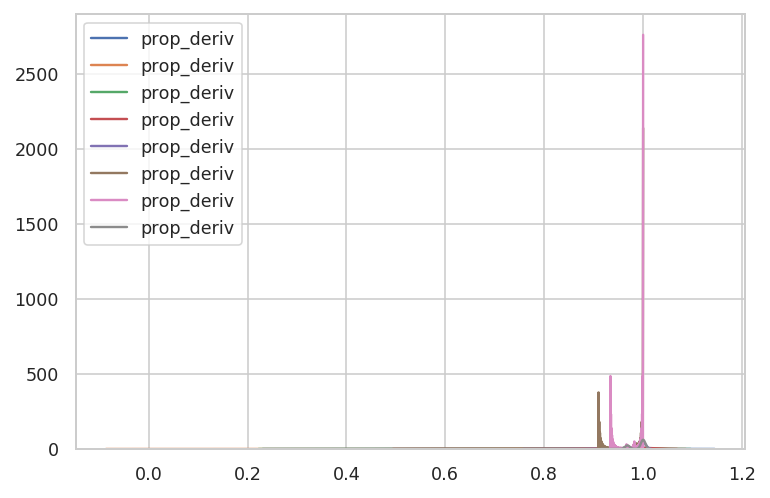

In [40]:
for cut in merged_data.clade_size_group.unique().sort_values():
    sns.kdeplot(merged_data.loc[(merged_data.clade_size_group == cut)].prop_deriv, shade=True);


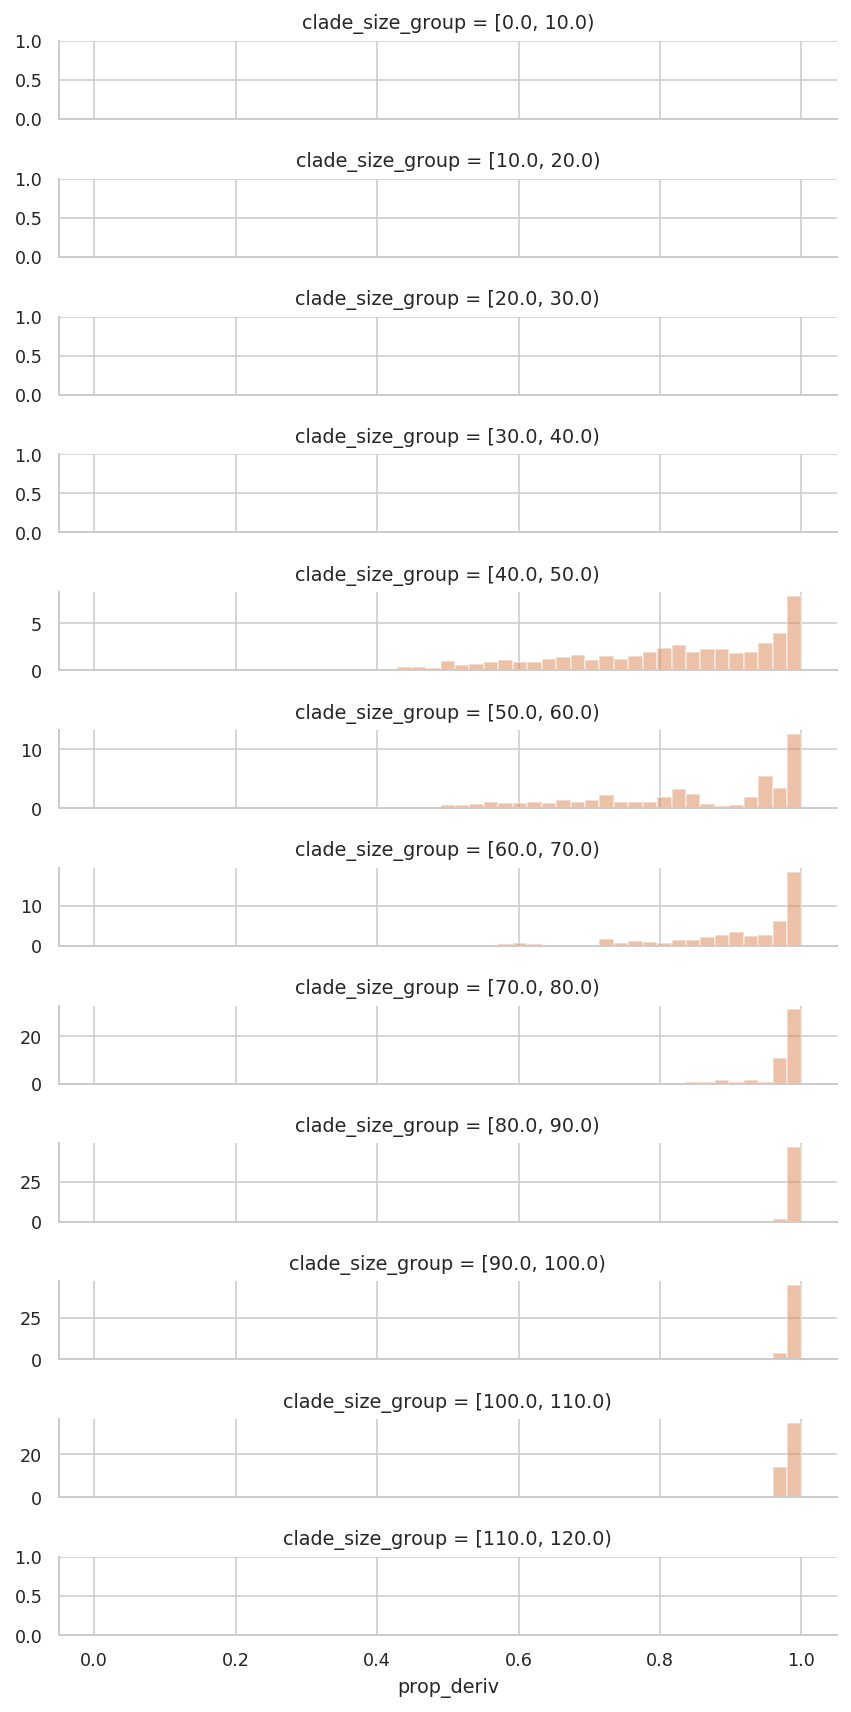

In [41]:
merged_data['clade_size_group'] = pd.cut(merged_data.clade_size, np.linspace(0, 120, 13), right=False)

grid = sns.FacetGrid(merged_data, row='clade_size_group', hue='swept', aspect=6, height=1, sharey=False)
grid.map(plt.hist, 'prop_deriv', density=True, bins=np.linspace(0, 1, 50), alpha=0.5) ;